In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from math import sqrt

# ETS

In [3]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [4]:
df_max = pd.read_csv('zillow-carlifornia.csv')
df_max = df_max.dropna()

In [5]:
#1. ETS

#first define mape to evaluate ETS models
def evaluate_es_model_mape(X,Trend, Seasonal,m,damped=True):
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend,seasonal=Seasonal,seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    mape=(np.abs(np.array(test)-np.array(predictions))/np.array(test)).mean()
    return mape

In [6]:
df_max.tail(5)  # this file has train/valid, test is already separated

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
90,2015-08-31,475000.0,3.95,5.2
91,2015-09-30,470000.0,3.87,5.1
92,2015-10-31,470000.0,3.80,5.0
93,2015-11-30,485750.0,3.69,5.0
94,2015-12-31,485000.0,3.89,5.1


In [7]:
valid = df_max[df_max['Date'].str.startswith('2015')]
history = df_max.iloc[0:len(df_max) - len(valid)]  # get train set

In [8]:
# test for later
test_df = pd.read_csv('test.csv')
test_df = test_df.set_index('Month')


In [9]:
# now let's find some ETS models
ms = range(2, 15)
mdict = {}
X=np.array(history['MedianSoldPrice_AllHomes.California'])+1 #adding 1 to avoide 0 sales 
# X = np.array(df_max['MedianSoldPrice_AllHomes.California']) + 1
for m in ms:
    mdict[m] = []
    mape_1=evaluate_es_model_mape(X, Trend="additive", Seasonal="additive",m=m,damped=True)
    mape_2=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="additive",m=m,damped=True)
    mape_3=evaluate_es_model_mape(X, Trend="additive", Seasonal="multiplicative",m=m,damped=True)
    mape_4=evaluate_es_model_mape(X, Trend="multiplicative", Seasonal="multiplicative",m=m,damped=True)
    mape_5=evaluate_es_model_mape(X, Trend=None, Seasonal="additive",m=m,damped=False)
    mape_6=evaluate_es_model_mape(X, Trend=None, Seasonal="multiplicative",m=m,damped=False)
    mdict[m].append(mape_1)
    mdict[m].append(mape_2)
    mdict[m].append(mape_3)
    mdict[m].append(mape_4)
    mdict[m].append(mape_5)
    mdict[m].append(mape_6)

In [10]:
best = [9999999, None]
for key in mdict:
    print(key)
    for val in mdict[key]:
        print(val)
        if val < best[0]:
            best[0] = val
            best[1] = key
    print('---')
print(best)

2
0.018906835727399575
0.020765963717369364
0.018862159913181825
0.019271536952439335
0.016259616515772114
0.016384837081232825
---
3
0.016116486791482726
0.017070005156188842
0.016035974051218604
0.015928966220885576
0.014665481780796507
0.014416318041547452
---
4
0.019048273226976636
0.020005565098822797
0.019720855145509173
0.02138368413841793
0.017695361301063302
0.017810174753982968
---
5
0.022643848564497936
0.07185677831922532
0.022137890149397592
0.022037262522426482
0.01967134357890158
0.019857654033320578
---
6
0.018605525803996388
0.11954795416244457
0.019390408517265936
0.020708152854745872
0.016417545409614664
0.017285689932659488
---
7
0.019929649753043233
8228.264153442287
0.026391016607966934
0.019402435933196335
0.019075716778023215
0.020005218620523808
---
8
0.02609106707408449
2866458554250.054
0.0609396784457655
1.3951028077428744
0.02248816726761558
0.045550139949465024
---
9
0.020295171851413246
3509213317122928.0
0.03438836522554774
72804279.13278224
0.0197889273

### Best ETS model:
Trend=None, Seasonal="multiplicative",m=3,damped=False

In [11]:
# fit best ETS model
model_ets=ExponentialSmoothing(history['MedianSoldPrice_AllHomes.California'], trend=None, seasonal="multiplicative", damped=False, seasonal_periods=3)
result_ets=model_ets.fit()
pred_ets=result_ets.forecast(len(valid))
pred_ets.index=valid.index

# get MAPE against validation set
mape_valid_ets=(np.abs(np.array(valid['MedianSoldPrice_AllHomes.California'])-np.array(pred_ets))/np.array(valid['MedianSoldPrice_AllHomes.California'])).mean()
print(mape_valid_ets)

0.05554292266249264


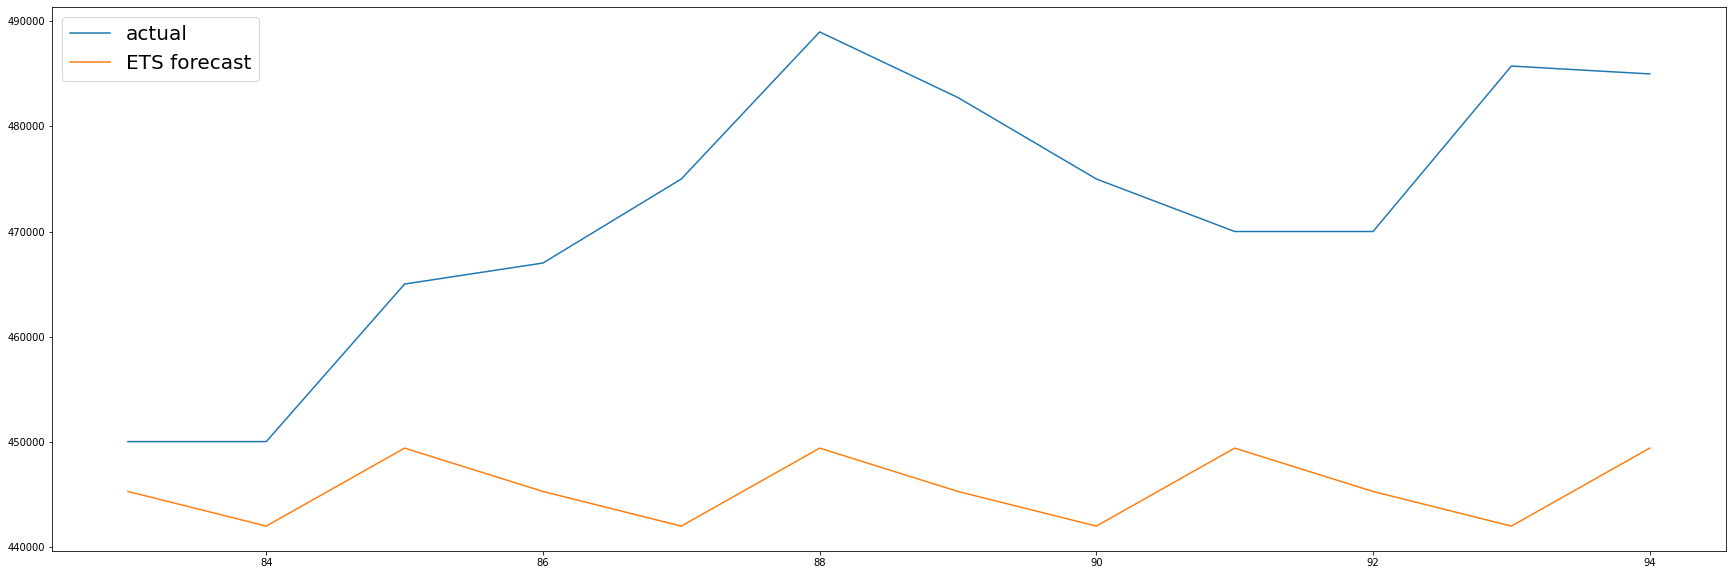

In [12]:
plt.figure(figsize=(30, 10))
#plt.plot(history, label='history')
plt.plot(valid['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(pred_ets, label='ETS forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

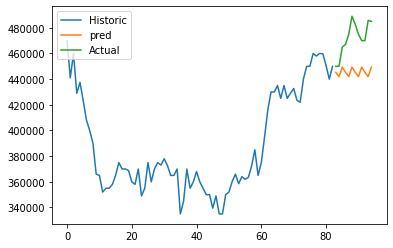

In [13]:
plt.plot(history['MedianSoldPrice_AllHomes.California'], label = "Historic")
plt.plot(pred_ets, label = 'pred')
plt.plot(valid['MedianSoldPrice_AllHomes.California'], label = 'Actual')
plt.legend(loc='upper left', fontsize=10)

In [14]:
# fit all together (train + validation)
model_ets_final=ExponentialSmoothing(df_max['MedianSoldPrice_AllHomes.California'], trend=None, seasonal="multiplicative", damped=False, seasonal_periods=3)
result_ets_final=model_ets_final.fit()
pred_ets_final=result_ets_final.forecast(len(test_df))
#pred_ets_final.index=test_df.index

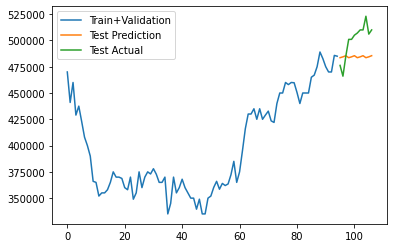

In [15]:
test_df.index = pred_ets_final.index
plt.plot(df_max['MedianSoldPrice_AllHomes.California'], label = "Train+Validation")
plt.plot(pred_ets_final, label = 'Test Prediction')
plt.plot(test_df['Median House Price'], label = 'Test Actual')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [16]:
sqrt(mean_squared_error(test_df['Median House Price'], pred_ets_final))

21947.554766867037

# Prophet

In [18]:
from fbprophet import Prophet

In [19]:
history_prophet = history[['Date','MedianSoldPrice_AllHomes.California']]
history_prophet=history_prophet.rename(columns={"Date": "ds","MedianSoldPrice_AllHomes.California":"y"})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


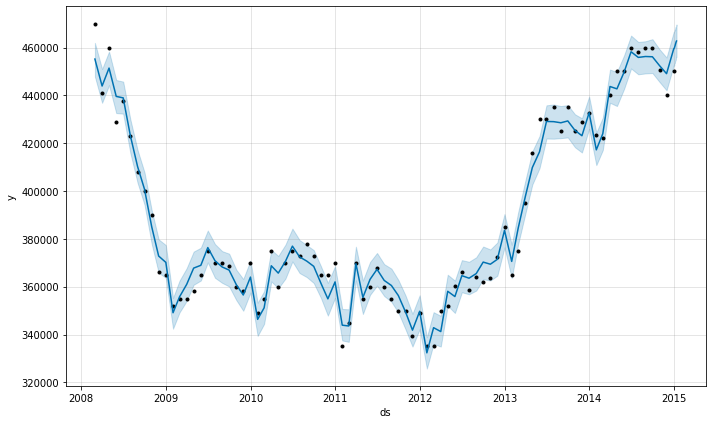

In [20]:
m = Prophet()
m.fit(history_prophet)
future = m.make_future_dataframe(periods=len(valid))
forecast = m.predict(future)
m.plot(forecast)
plt.show()

In [21]:
pred_p = forecast["yhat"][len(history_prophet):]
pred_p.index=valid.index

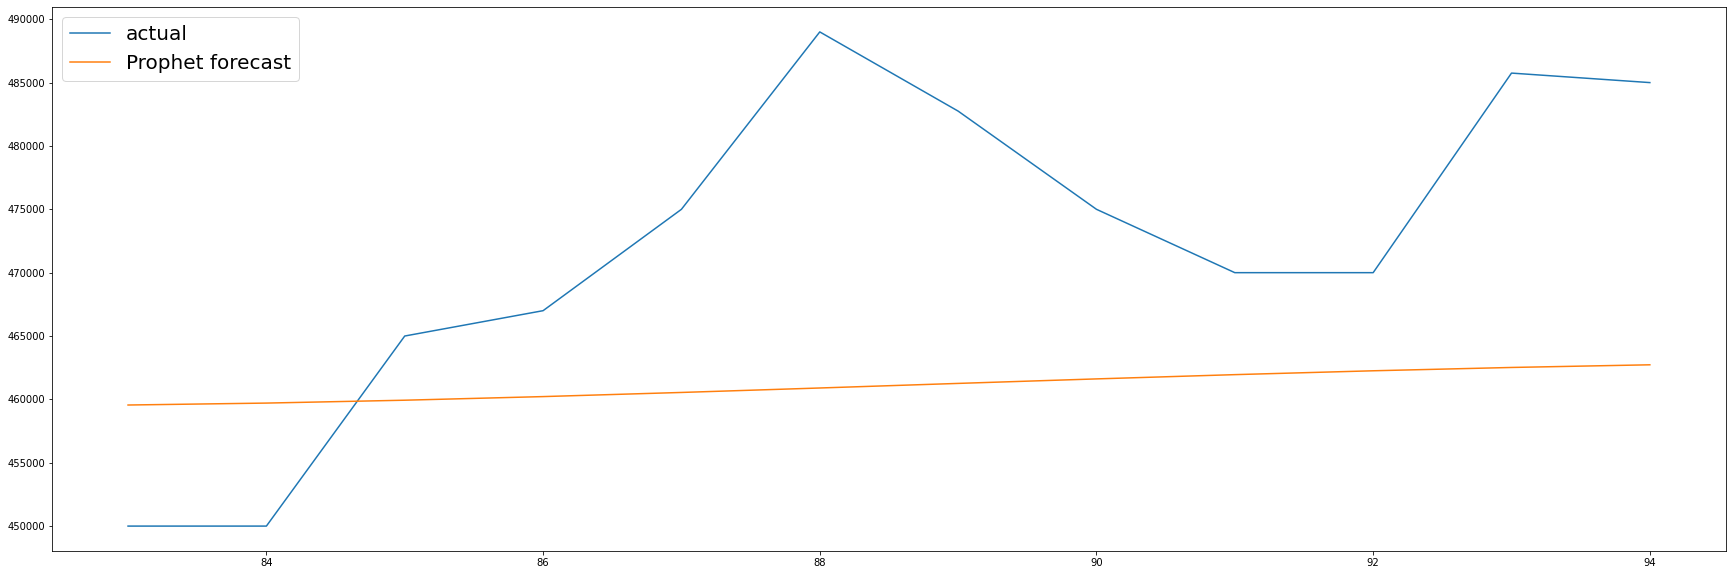

In [22]:
plt.figure(figsize=(30, 10))

plt.plot(valid['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(pred_p, label='Prophet forecast')
plt.legend(loc='upper left', fontsize=20)
plt.show()

In [23]:
mape_valid_prophet = (np.abs(np.array(valid['MedianSoldPrice_AllHomes.California'])-np.array(pred_p))/np.array(valid['MedianMortageRate'])).mean()
mape_valid_prophet

3692.956716703609

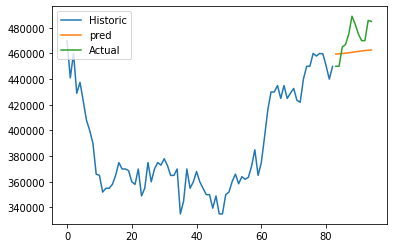

In [24]:
plt.plot(history['MedianSoldPrice_AllHomes.California'], label = "Historic")
plt.plot(pred_p, label = 'pred')
plt.plot(valid['MedianSoldPrice_AllHomes.California'], label = 'Actual')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [25]:
# redo for complete
history_prophet_tog = df_max[['Date','MedianSoldPrice_AllHomes.California']]
history_prophet_tog=history_prophet_tog.rename(columns={"Date": "ds","MedianSoldPrice_AllHomes.California":"y"})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


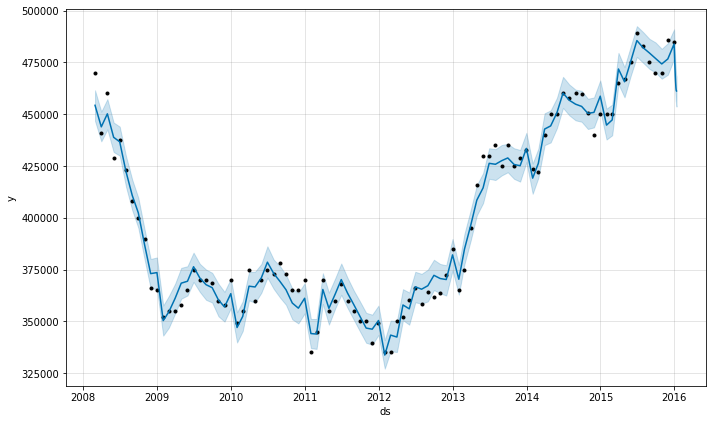

In [26]:
m = Prophet()
m.fit(history_prophet_tog)
future = m.make_future_dataframe(periods=len(test_df))
forecast = m.predict(future)
m.plot(forecast)
plt.show()

In [27]:
pred_p_final = forecast["yhat"][len(history_prophet_tog):]
pred_p_final.index=test_df.index

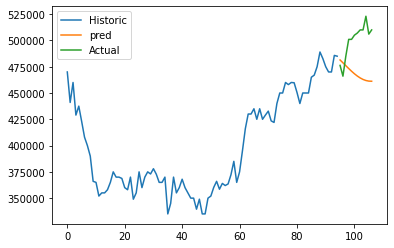

In [28]:
plt.plot(df_max['MedianSoldPrice_AllHomes.California'], label = "Historic")
plt.plot(pred_p_final, label = 'pred')
plt.plot(test_df['Median House Price'], label = 'Actual')
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [29]:
sqrt(mean_squared_error(test_df['Median House Price'], pred_p_final))

38070.80748150975

# SARIMA

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from math import sqrt

In [31]:
df = pd.read_csv('zillow-carlifornia.csv')

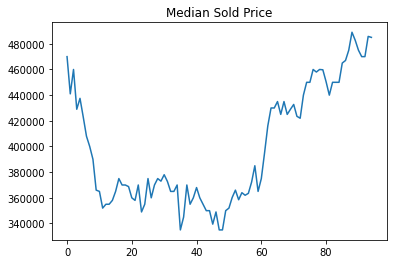

In [32]:
plt.plot(df['MedianSoldPrice_AllHomes.California'])
plt.title('Median Sold Price')
plt.show()

In [33]:
# define all the functions we will need 

# trend and seasonal differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
#trend differencing: interval=1
#seasonal differencing: interval=m


#grid order search based on BIC
#auto-arima order selection in pmdarima
#python -m pip install pmdarima doesn't work for my python 3.9 anymore, so I wrote one

def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m_values, D=1): #added m_values
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                for m in m_values:
                                    order=(p,d,q)
                                    seasonal_order=(P,D,Q,m)
                                    try:
                                        res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                        bic=res.bic
                                        if bic < best_score:
                                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                    except:
                                        continue
    print((best_score, best_order, best_seasonal_order))
    
#model evaluation based on RMSE and one-step cross validation
def rmse_sarima(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_rmse_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    rmse=rmse_sarima(data,trend_order=order, seasonal_order=seasonal_order)
                                    if rmse < best_score:
                                        best_score, best_order, best_seasonal_order=rmse, order,seasonal_order
                                except:
                                    continue
    print((best_score, best_order, best_seasonal_order))

In [34]:
df = df.dropna()

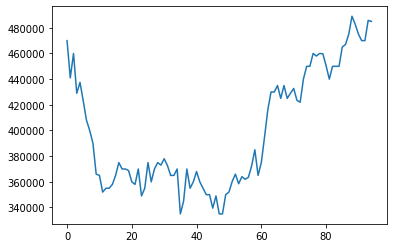

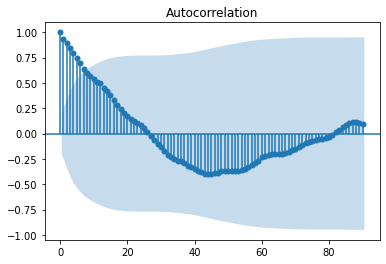

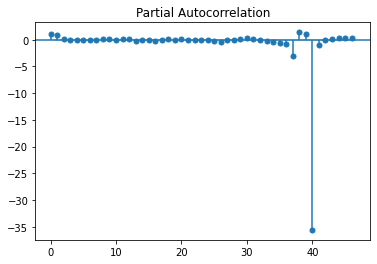

In [35]:
plt.plot(df['MedianSoldPrice_AllHomes.California'])
plt.show()
plot_acf(df['MedianSoldPrice_AllHomes.California'],lags=90) 
plt.show()
plot_pacf(df['MedianSoldPrice_AllHomes.California'],lags=46) 
plt.show()

In [36]:
d2 = diff(df['MedianSoldPrice_AllHomes.California'], 1)
dftest = adfuller(d2)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


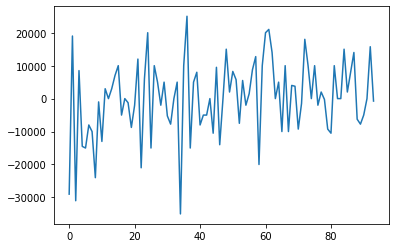

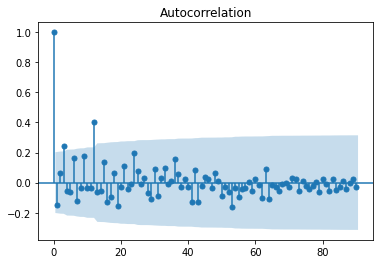

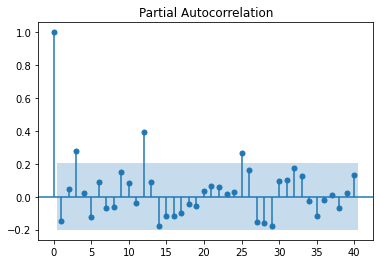

In [37]:
plt.plot(d2)
plt.show()
plot_acf(d2,lags=90) 
plt.show()
plot_pacf(d2,lags=40) 
plt.show()

In [38]:
d2 = diff(df['MedianSoldPrice_AllHomes.California'], 2)
dftest = adfuller(d2)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.374527
p-value           0.011859
dtype: float64


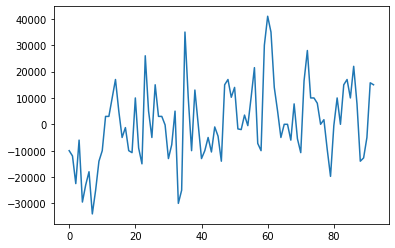

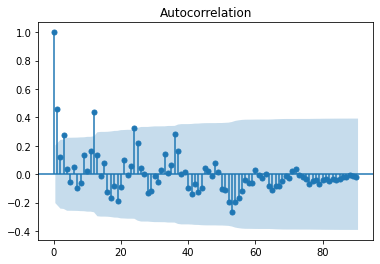

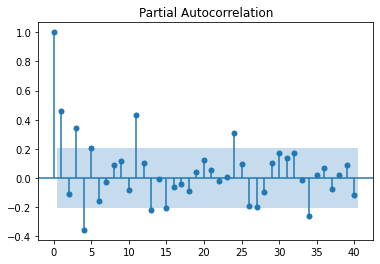

In [39]:
plt.plot(d2)
plt.show()
plot_acf(d2,lags=90) 
plt.show()
plot_pacf(d2,lags=40) 
plt.show()

In [40]:
m_values=[12, 13]
d_values=[1,2]
p_values=[0,1,2,3]
q_values=[0,1,2,3]
Q_values=[0,1,2,3]
P_values=[0,1,2,3]

bic_sarima(df['MedianSoldPrice_AllHomes.California'], p_values,d_values,q_values,P_values,Q_values,m_values, D=1)

(23.590953796345953, (1, 2, 2), (0, 1, 2, 13))


In [41]:
valid = df[df['Date'].str.startswith('2015')]

In [42]:
history = df.iloc[0:83]

In [43]:
mod = sm.tsa.statespace.SARIMAX(history['MedianSoldPrice_AllHomes.California'] ,order=(2,1,1),seasonal_order=(3,1,2,12))
res = mod.fit()
pred=res.predict(start=len(history), end=len(history)+len(valid)-1)

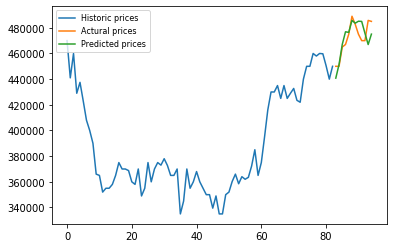

In [44]:
valid['pred_price'] = pred.values
plt.plot(history['MedianSoldPrice_AllHomes.California'],label='Historic prices')
plt.plot(valid['MedianSoldPrice_AllHomes.California'],label='Actural prices')
plt.plot(valid['pred_price'],label='Predicted prices')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [45]:
sqrt(mean_squared_error(valid['MedianSoldPrice_AllHomes.California'], pred))

9192.216412324728

In [46]:
test = pd.read_csv('test.csv')

In [47]:
test_pred=res.predict(start=len(df), end=len(df)+len(test)-1)

In [48]:
test = test.set_index('Month')

In [49]:
df = df.set_index('Date')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

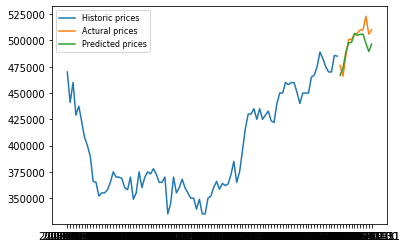

In [50]:
test['pred_price'] = test_pred.values
plt.plot(df['MedianSoldPrice_AllHomes.California'],label='Historic prices')
plt.plot(test['Median House Price'],label='Actural prices')
plt.plot(test['pred_price'],label='Predicted prices')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
sqrt(mean_squared_error(test['Median House Price'], test_pred))

10581.734460223524

In [52]:
test['pred_price'].to_csv('preds.csv')

In [53]:
def MAPE(targs, preds):
    return np.mean(np.divide(np.abs(np.subtract(preds, targs)), targs))

In [54]:
MAPE(test['Median House Price'], test_pred)

nan

# SARIMAX

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
from math import sqrt

In [56]:
df = pd.read_csv('zillow-carlifornia.csv')

In [57]:
df = df.set_index('Date')

In [58]:
df.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


In [59]:
df.isnull().sum()

MedianSoldPrice_AllHomes.California    12
MedianMortageRate                       0
UnemploymentRate                        0
dtype: int64

In [60]:
df = df.dropna()

In [61]:
# Use VIF to verify multicolinearity among price, mortgage rate and unemployment rate,
# so it's reasonable to include them all in multivariate time series model.
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    
    return(vif)

In [62]:
calc_vif(df)

,variables,VIF
0,MedianSoldPrice_AllHomes.California,32.007041
1,MedianMortageRate,39.200367
2,UnemploymentRate,25.361427


In [63]:
#normalize the features for better prediction
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(df)
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input
X.rename(columns={0:'price', 1:'mortgage', 2:'unemp'}, inplace=True)
X.head()

,price,mortgage,unemp
0,0.876623,0.729927,0.317073
1,0.688312,0.784672,0.292683
2,0.811688,0.777372,0.341463
3,0.610390,0.795620,0.317073
4,0.665584,0.843066,0.292683


In [64]:
#define y: "future" price, here we can take the house price of next month
steps=-1
df['y']=df['MedianSoldPrice_AllHomes.California'].shift(steps)
df.tail()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,y
Date,,,,
2015-08-31,475000.0,3.95,5.2,470000.0
2015-09-30,470000.0,3.87,5.1,470000.0
2015-10-31,470000.0,3.80,5.0,485750.0
2015-11-30,485750.0,3.69,5.0,485000.0
2015-12-31,485000.0,3.89,5.1,NaN


In [65]:
#transform y as well
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(df[['y']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [66]:
y.rename(columns={0:'future price'}, inplace= True)
y.index=df.index
y.head(5)

,future price
Date,
2008-02-29,0.688312
2008-03-31,0.811688
2008-04-30,0.610390
2008-05-31,0.665584
2008-06-30,0.571429


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


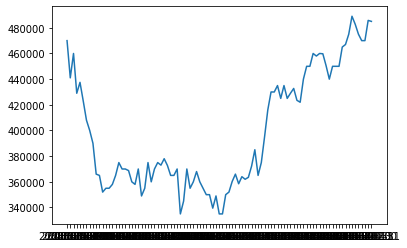

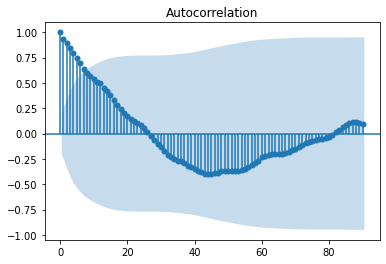

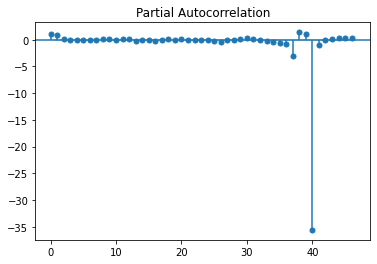

In [67]:
plt.plot(df['MedianSoldPrice_AllHomes.California'])
plt.show()
plot_acf(df['MedianSoldPrice_AllHomes.California'],lags=90) 
plt.show()
plot_pacf(df['MedianSoldPrice_AllHomes.California'],lags=46) 
plt.show()

In [68]:
#split train and test, make validation set everything from 2015
period=12
train_X, train_y = X[:-period].dropna(), y[:-period].dropna()
test_X, test_y = X[-period:].dropna(), y[-period:].dropna()
train_X = train_X .set_index(train_y.index)

In [71]:
#auto sarimax search with m=12
from pmdarima.arima import auto_arima
model=auto_arima(train_y, 
                 exogenous= train_X,
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=2,
                 trace=True,seasonal=True,D=1,m=12, max_P=4, max_Q=4, #add seasonality
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-173.387, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-181.319, Time=2.00 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-182.744, Time=3.39 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-173.362, Time=0.15 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-182.707, Time=0.57 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-186.107, Time=5.92 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-181.370, Time=3.79 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-182.916, Time=10.81 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-186.602, Time=10.17 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=10.11 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=-184.705, Time=12.10 sec
 ARIMA(0,0,1)(1,1,3)[12] intercept   : AIC=inf, Time=15.30 sec
 ARIMA(0,0,1)(0,1,3)[12] intercept   : AIC=-186.952, Time=15.41 sec
 ARIMA(0,0,1)(0,1,4)[12] int

In [72]:
y_pred = model.predict(n_periods=len(test_y),X=test_X.iloc[:-1,:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,2,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc_out.inverse_transform(y_pred_)[:,-1] 
y_pred_inv

array([445629.84559098, 461586.32984667, 467907.10578075, 464293.30099892,
       484701.29790295, 481782.30446579, 487075.94457703, 469071.86293828,
       462612.17534669, 463179.21089065, 494853.02401799])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


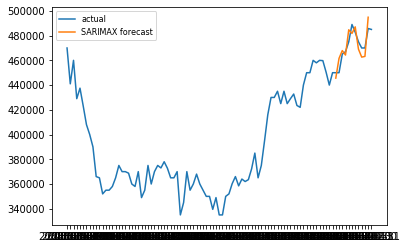

In [73]:
y_pred_series = pd.Series(y_pred_inv,index=test_y.index)
plt.plot(df['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [74]:
rmse = sqrt(mean_squared_error(df['MedianSoldPrice_AllHomes.California'][83:-1], y_pred_series))
rmse

7091.312554259631

In [75]:
mape=(np.abs(np.array(df['MedianSoldPrice_AllHomes.California'][83:-1])-np.array(y_pred_series))/np.array(df['MedianSoldPrice_AllHomes.California'][83:-1])).mean()
mape

0.01391846283789595

In [76]:
#auto sarimax search with m=3
from pmdarima.arima import auto_arima
model=auto_arima(train_y, 
                 exogenous= train_X,
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=2,
                 trace=True,seasonal=True,D=1,m=3, max_P=4, max_Q=4, #add seasonality
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[3] intercept   : AIC=-190.289, Time=2.88 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=-176.917, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=-183.282, Time=0.97 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=-195.371, Time=2.83 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=-178.810, Time=0.22 sec
 ARIMA(0,0,1)(0,1,0)[3] intercept   : AIC=-177.498, Time=0.38 sec
 ARIMA(0,0,1)(1,1,1)[3] intercept   : AIC=-193.500, Time=3.51 sec
 ARIMA(0,0,1)(0,1,2)[3] intercept   : AIC=-193.421, Time=4.28 sec
 ARIMA(0,0,1)(1,1,0)[3] intercept   : AIC=-183.047, Time=0.91 sec
 ARIMA(0,0,1)(1,1,2)[3] intercept   : AIC=-191.395, Time=2.29 sec
 ARIMA(0,0,0)(0,1,1)[3] intercept   : AIC=-192.814, Time=1.19 sec
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=-193.981, Time=1.91 sec
 ARIMA(0,0,2)(0,1,1)[3] intercept   : AIC=-193.735, Time=1.77 sec
 ARIMA(1,0,0)(0,1,1)[3] intercept   : AIC=-196.051, Time=1.60 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept

In [77]:
y_pred = model.predict(n_periods=len(test_y),X=test_X.iloc[:-1,:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,2,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc_out.inverse_transform(y_pred_)[:,-1] 
y_pred_inv

array([444059.74616215, 453842.56275401, 456346.56505767, 458951.76133021,
       476472.22211898, 479838.62588896, 473378.03097084, 475259.83109043,
       459840.24824728, 460275.29275871, 485333.87266012])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


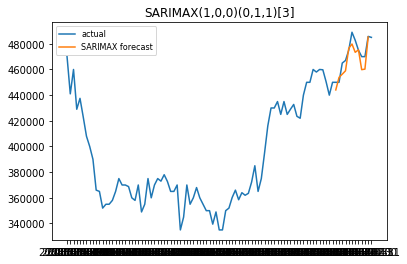

In [78]:
y_pred_series = pd.Series(y_pred_inv,index=test_y.index)
plt.plot(df['MedianSoldPrice_AllHomes.California'], label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=8)
plt.title('SARIMAX(1,0,0)(0,1,1)[3]')
plt.show()

In [79]:
rmse = sqrt(mean_squared_error(df['MedianSoldPrice_AllHomes.California'][83:-1], y_pred_series))
rmse

7145.699049596961

In [80]:
mape=(np.abs(np.array(df['MedianSoldPrice_AllHomes.California'][83:-1])-np.array(y_pred_series))/np.array(df['MedianSoldPrice_AllHomes.California'][83:-1])).mean()
mape

0.012958375484590041

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=671ff8d8-6ae5-4350-af13-1db4485fe857' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>